# Tutorial 03 - Visualize scan path on surface

In this tutorial we will look at how to load surface data that was exported from Pupil Player into Python to visualize gaze positions and fixations on the surface.

1. Load a reference image.
1. Load the data using `Pandas`
1. Visualize fixation data as scan path on 1 surface for 1 participant.
1. Visualize fixation data as scan path on 1 surface for multiple participants.

1 - Loading libaries and reference image

In this example, participants were asked to look at the cover of a magazine. We can quickly load the reference image (either from a file or from a url). 

_Note_ you can modify this to load from a file instead of url. 

In [1]:
import numpy as np
from scipy.ndimage import rotate
from urllib.request import urlopen, Request
import matplotlib.pyplot as plt


user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/535.19 (KHTML, like Gecko) Ubuntu/12.04 Chromium/18.0.1025.168 Chrome/18.0.1025.168 Safari/535.19'
url = "https://cdn.technologyreview.com/i/images/mag.coverx1004_2.jpg?sw=800"
magazine_cover_ref_file = urlopen(Request(url, headers={'User-Agent': user_agent}))
magazine_cover_ref_image = np.fliplr(rotate(plt.imread(magazine_cover_ref_file, format='jpg'), 180))

## 2 - Loading exported fixation data on surface

Now lets see how to load the exported fixation data for this surface. The file will be named with the pattern `fixations_on_surface_<your-surface-name>_<uid>.csv`

In [2]:
import os
import pandas as pd

recordings_location = '/home/pupil-labs/recordings'
demo_recording = '2019_02_15/000'
file_name = 'fixations_on_surface_magazine_cover_1550027153.7953088.csv'
exported_surface_csv = os.path.join(recordings_location, demo_recording, 
                                    'exports', '001', 'surfaces', file_name)
surface_pd_frame = pd.read_csv(exported_surface_csv)

print("Columns present in exported fixation on surface data:\n {}".format(surface_pd_frame.columns))

Columns present in exported fixation on surface data:
 Index(['id', 'start_timestamp', 'duration', 'start_frame', 'end_frame',
       'norm_pos_x', 'norm_pos_y', 'x_scaled', 'y_scaled', 'on_srf'],
      dtype='object')


### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `id` - The id of the fixation. A sequential integer that shows the number of the fixation in order.
- `start_timestamp` - The starting timestamp of the fixation.
- `duration` - The duration of the fixation.
- `start_frame` - The world frame associated with the start of this fixation.
- `end_frame` - The world frame associated with the end of this fixation.
- `x_norm` - the normalized x position of the fixation relative to the surface. (0,0) is the bottom left corner of the surface; (1,1) is the top right corner of the surface. Note that coordinates outside of the 0-1 bounds are possible which means that the fixation is **not** on the surface. 
- `y_norm` - the normalized y position of the fixation relative to the surface.
- `x_scaled` and `y_scaled` - the position of the fixation relative to the surface scaled relative to the specified size of the surface. The size is defined in Pupil Player or Pupil Capture. 
- `on_srf` - boolean value if gaze is within the bounds of the surface

Let's take a look at a few values from our sample surface data!

In [3]:
fixation_on_srf = surface_pd_frame[surface_pd_frame.on_srf == True]
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("fixation on (magazine surface) data:\n {}".format(fixation_on_srf[headers][:5]))

fixation on (magazine surface) data:
    id  start_timestamp  duration  start_frame  end_frame  norm_pos_x  \
1   1       346700.939   996.385           53        111       0.127   
2   2       346701.946   801.114          112        147       0.181   
3   3       346703.212   518.220          169        189       0.174   
4   4       346703.741   998.889          189        237       0.584   
5   5       346704.742   998.889          238        292       0.619   

   norm_pos_y  x_scaled  y_scaled  on_srf  
1       0.899    50.822   449.432    True  
2       0.866    72.565   433.173    True  
3       0.807    69.783   403.356    True  
4       0.928   233.768   464.138    True  
5       0.908   247.662   454.113    True  


## 3 - Visualize fixation data on surface for single participant

Now we visualize fixation data on this surface.

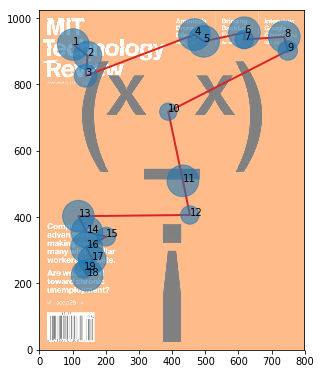

In [4]:
from scipy.ndimage.filters import gaussian_filter

grid = (1024,800) # this should match the real world size of the image

# scale up the normalized coordinates for x and y 
x = fixation_on_srf["norm_pos_x"]*grid[1]
y = fixation_on_srf["norm_pos_y"]*grid[0]
point_scale = fixation_on_srf["duration"]
id_labels = list(fixation_on_srf["id"])

# display reference image
plt.figure(figsize=(8,6.25))
ax = plt.gca() # get plot current axes for annotation

ref_image = plt.imshow(magazine_cover_ref_image, interpolation=None, alpha=0.5, origin="lower")

# display the lines and points for fixation
polyline = plt.plot(x, y, "C3", zorder=1, lw=2)
# use the duration to determine the scatter plot circle radius
points = plt.scatter(x, y, zorder=2, s=point_scale, alpha=0.6)

for i, l in enumerate(id_labels):
    ax.annotate(s=str(l), xy=(list(x)[i], list(y)[i]))

plt.show()

## 3 - Visualize fixation data on surface for multiple participants

Now we visualize fixation data on this surface for multiple participants

In [ ]:
from glob import glob

demo_recordings_path = '2019_02_15'
surface_path_pattern = '**/exports/**/surfaces/fixations_on_surface_magazine_cover_*.csv'
surface_files = glob(os.path.join(recordings_location, demo_recordings_path, surface_path_pattern), 
                     recursive=True)

surface_pd_frames = pd.DataFrame()
for fp in surface_files:
    frame = pd.read_csv(fp)
    
    surface_pd_frames = surface_pd_frames.append(frame)